In [1]:
import time
import os
import math
import tushare as ts
from datetime import datetime
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from IPython.display import clear_output

sys.path.append("../utils/")
import date_util
import token_util
import enter_util
import stock_util

### 提取数据

In [2]:
trade_date = "20190830"
delta_price = 30.0

In [ ]:
stock_list = stock_util.get_stock_list(trade_date, delta_price)

In [3]:
stock_list = pd.read_csv("../data_pulled/stock_{}.csv".format(trade_date))
stock_list.head()

,ts_code,name,price
0,000001.SZ,平安银行,14.145
1,000002.SZ,万科A,25.885
2,000004.SZ,国农科技,20.090
3,000005.SZ,世纪星源,3.135
4,000006.SZ,深振业A,5.360


### 选出符合入场点的股票

In [4]:
# 选股

end_date = '20190930'
start_date = date_util.get_date_weeks_before(2, date=end_date)

golden_list = []

columns = ["stock_code", "pct_chg_short", "his_macd_discount", "amount_mean"]
choose_list = pd.DataFrame(columns = columns)

for i in range(len(stock_list)):
    stock_code = stock_list.iloc[i]["ts_code"]
    
    try:
        ma7_1, ma7_2, ma14_1, ma14_2, amount_mean, ptc_chg_short = enter_util.cal_ma(stock_code, start_date, end_date)

        if ma7_1 < ma14_1 and ma7_2 > ma14_2 :

            golden_list.append(stock_code)
            macd, data_macd, his_macd_discount, macd_trend = enter_util.cal_macd(stock_code, end_date, multi_output=True)
            list_tmp = pd.DataFrame([[stock_code, ptc_chg_short, his_macd_discount, amount_mean]], columns=columns)

            if macd > 0:
                if macd_trend:
                    choose_list = choose_list.append(list_tmp)
#             else:
#                 if enter_util.negetive_macd_judge(data_macd) :
#                     choose_list = choose_list.append(list_tmp)
    except:
        time.sleep(3)
    
    if i % 100 == 0:
        clear_output(True)
        print(i)
        print(choose_list)

# 数据归一化

for column in choose_list.columns[1:]:
    c_data = choose_list[column]
    choose_list[column] = (c_data-c_data.min())/(c_data.max() - c_data.min())

# 排序

def get_rank_factor(arr):
    pct_chg_short = arr["pct_chg_short"] * 0.5
    his_macd_discount = arr["his_macd_discount"]
    amount_mean = arr["amount_mean"]
    return pct_chg_short+his_macd_discount+amount_mean

choose_list["rank_factor"] = choose_list.apply(get_rank_factor, axis = 1)
choose_list = choose_list.sort_values(by="rank_factor", ascending= False).reset_index(drop=True)

2600
  stock_code  pct_chg_short  his_macd_discount    amount_mean
0  000422.SZ         1.7643           0.557250   20687.255818
0  000429.SZ         0.3923           0.541750   25152.578727
0  000611.SZ         3.5079           0.544000    8469.332364
0  000707.SZ         6.4033           0.539250   17007.624273
0  000806.SZ         3.0364           0.561750   26268.826000
0  000895.SZ         2.9194           0.517750  371628.446818
0  002111.SZ        -0.5079           0.532030  227446.760818
0  002324.SZ         1.9616           0.554681   55106.132636
0  002351.SZ         7.7627           0.552052   99601.748000
0  002563.SZ         4.6279           0.525399   75795.938545
0  002627.SZ         3.9481           0.543592   15941.752909
0  002739.SZ         6.5093           0.565714  313876.144909
0  002741.SZ         2.2792           0.537396   93813.375364
0  002873.SZ         7.9619           0.584483   30644.369727
0  600201.SH         3.1303           0.530750  377268.151455
0  

# TEST

In [29]:
# 今世缘 603369.SH
# 韵达股份 002120.SZ
# ts_code = "603369.SH"
ts_code = "002127.SZ"
data= stock_util.cal_macd(ts_code)

neg_macd_mean = data["macd"][data["macd"] < 0].mean()

neg_diff_mean = data["diff"][data["diff"] < 0].mean()
neg_dea_mean = data["dea"][data["dea"] < 0].mean()
pos_diff_mean = data["diff"][data["diff"] > 0].mean()
pos_dea_mean = data["dea"][data["dea"] > 0].mean()

In [30]:
len(data)

2704

In [31]:
def plot(data, golden_port):
    
    plt.figure(figsize=(20,10))
    columns = 8
    rows = math.ceil(len(golden_port['index']) / columns)
    
    enter_true, enter_false = [], []
    num_plot = 1
    
    for i in range(rows):
        for j in range(columns):
            
            # 本行的图已画完
            if num_plot > len(golden_port['index']):
                break
            
            # 获取data中的当前索引
            index = golden_port['index'][num_plot-1]
            
            # 数据缺失
            if (index + 11) > len(data):
                break
            
            # 如果8天之后ema7还在ema4上方，则表示正确入场，否则表示错误入场
            if data["ema7"][index+8] > data["ema14"][index+8]:
                current_enter = "True"
                enter_true.append(golden_port['date'][num_plot-1])
            else:
                current_enter = "False"
                enter_false.append(golden_port['date'][num_plot-1])
            
            plt.subplot(rows, columns, num_plot)
            plt.title(str(index) + " " + golden_port['date'][num_plot-1] + " " + current_enter)
            plt.plot(data["ema7"][index:index + 10])
            plt.plot(data["ema14"][index:index + 10])
            plt.axis("off")
            num_plot += 1
    
    plt.show()
    
    enter_discount = len(enter_true) / (len(enter_true)+len(enter_false))
    
    return enter_true, enter_false, enter_discount

### TEST 1

* 获取金叉点

In [7]:
last_m7, last_m14 = data.iloc[0]['ema7'], data.iloc[0]['ema14']
this_m7, this_m14 = 0, 0
golden_port = {"index":[], "date":[]}

for i in range(len(data)):
    
    this_m7, this_m14 = data.iloc[i]['ema7'], data.iloc[i]['ema14']
    
    if (last_m7 < last_m14 and this_m7 > this_m14) or (last_m7 - last_m14 < 0.015 and this_m7 - this_m14 > 0) :
        golden_port["index"].append(i)
        golden_port["date"].append(data.iloc[i]['trade_date'])

    last_m7, last_m14 = this_m7, this_m14

In [8]:
len(golden_port["index"])

80

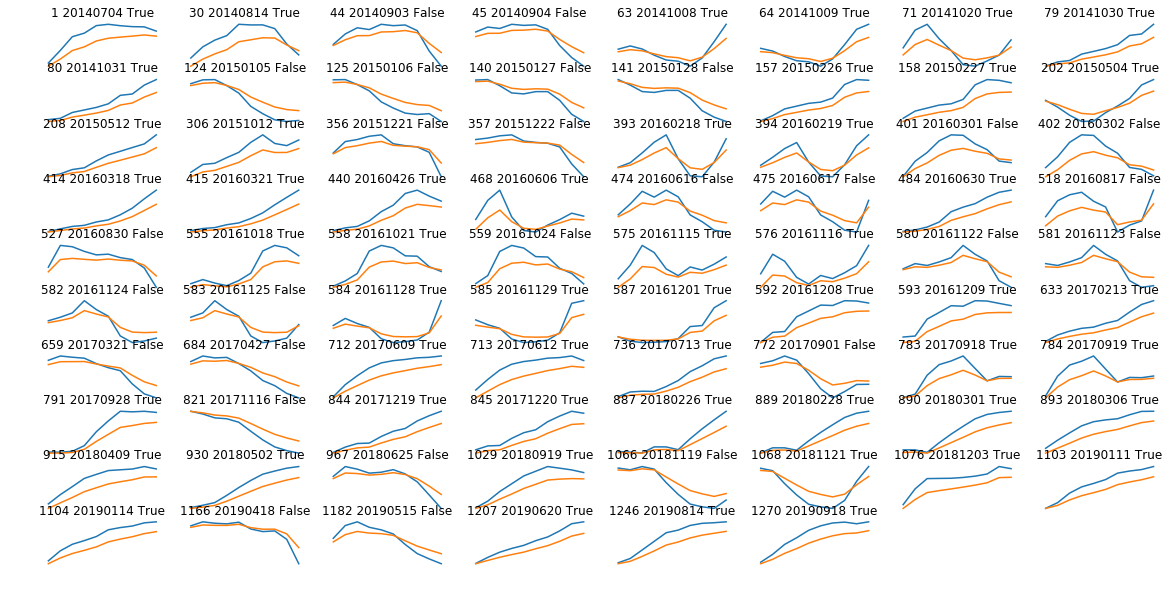

In [9]:
enter_true, enter_false, enter_discount = plot(data, golden_port)

In [10]:
enter_discount

0.6538461538461539

* MACD 优化

In [11]:
golden_port_macd = {"index":[], "date":[]}

for i in range(len(golden_port["index"])):
    index = golden_port["index"][i]
    
    if data["macd"][index] > neg_macd_mean:
        golden_port_macd["index"].append(index)
        golden_port_macd["date"].append(golden_port["date"][i])

In [12]:
len(golden_port_macd["index"])

77

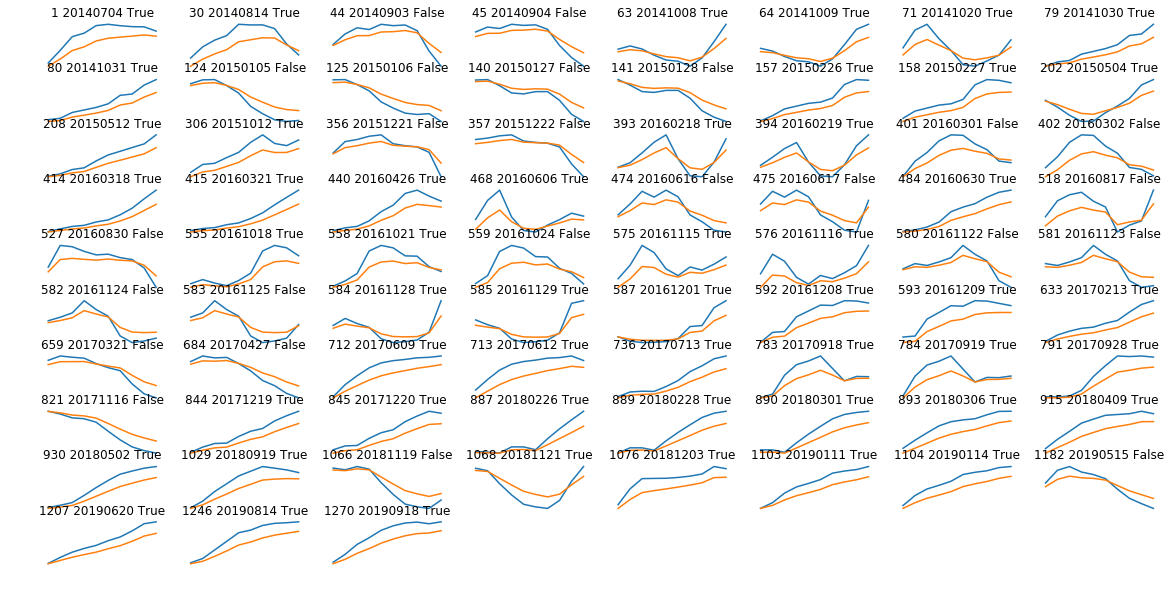

In [13]:
enter_true, enter_false, enter_discount_macd = plot(data, golden_port_macd)

In [14]:
enter_discount_macd

0.68

* dif dea 优化

In [15]:
golden_port_ddd = {"index":[], "date":[]}

for i in range(len(golden_port_macd["index"])):
    index = golden_port_macd["index"][i]
    
    if data["diff"][index] - data["dea"][index] > 0:
        if data["diff"][index] > neg_diff_mean and data["dea"][index] > neg_dea_mean:
            golden_port_ddd["index"].append(index)
            golden_port_ddd["date"].append(golden_port_macd["date"][i])

In [16]:
len(golden_port_ddd["index"])

50

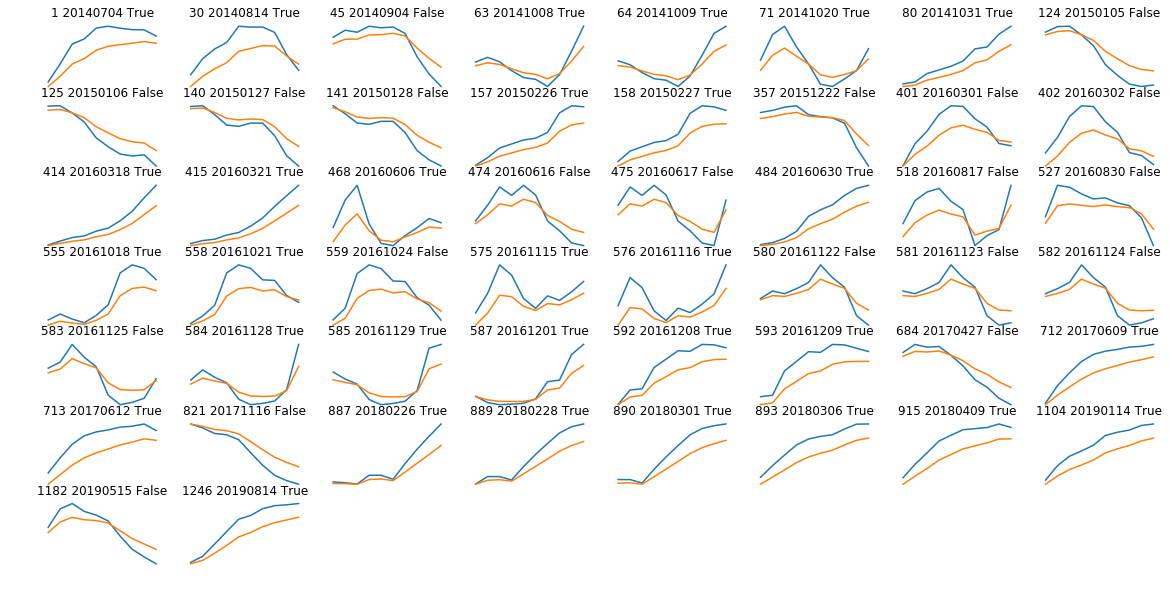

In [17]:
enter_true, enter_false, enter_discount_ddd = plot(data, golden_port_ddd)

In [18]:
enter_discount_ddd

0.6

### TEST 2

* 获取macd大于0的点

In [32]:
macd_port = {"index":[], "date":[]}
true_count = 0

for i in range(len(data)):
    
    if data["macd"][i] > 0:
        true_count += 1
        if true_count == 1:
            macd_port["index"].append(i)
            macd_port["date"].append(data.iloc[i]['trade_date'])
    
    else:
        true_count = 0
        continue

In [33]:
len(macd_port["index"])

105

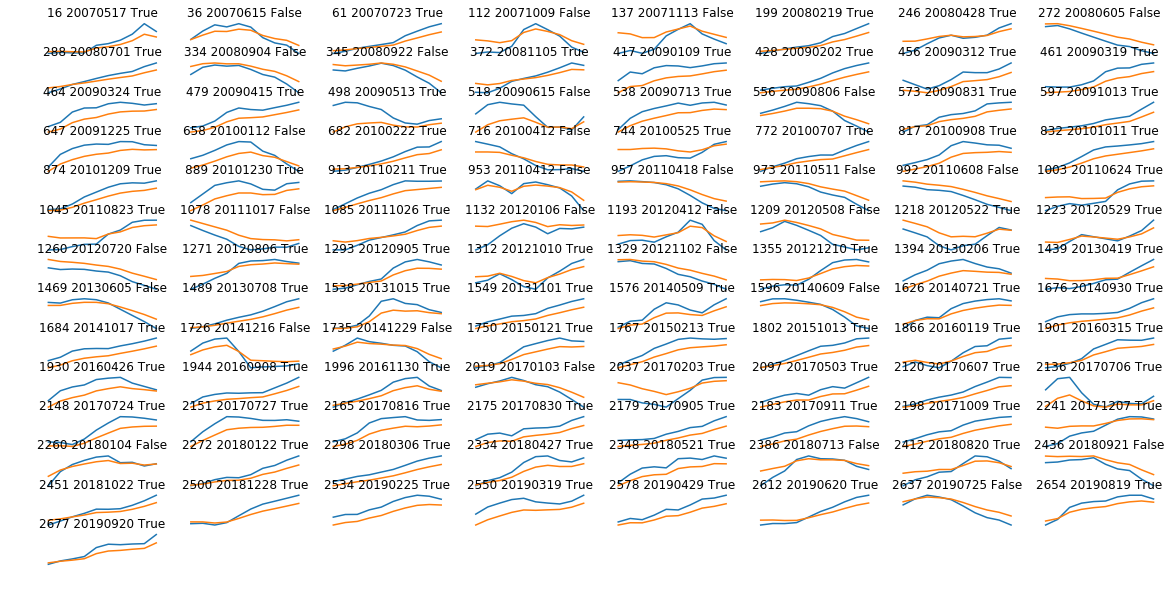

In [34]:
enter_true, enter_false, enter_discount = plot(data, macd_port)

In [35]:
enter_discount

0.7238095238095238

* dif dea 优化

In [36]:
macd_port_ddd = {"index":[], "date":[]}

for i in range(len(macd_port["index"])):
    index = macd_port["index"][i]
    
    if data["diff"][index] - data["dea"][index] > 0.001:
        if 0 < data["diff"][index] < pos_diff_mean and 0 < data["dea"][index] < pos_dea_mean:
            macd_port_ddd["index"].append(index)
            macd_port_ddd["date"].append(macd_port["date"][i])

In [37]:
len(macd_port_ddd["index"])

20

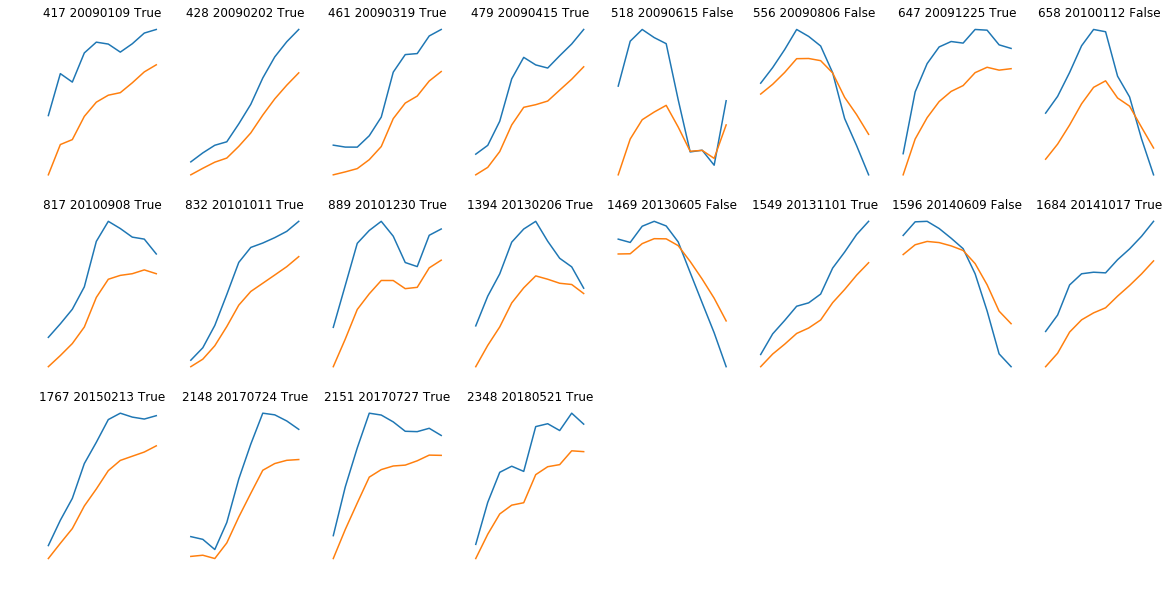

In [38]:
enter_true, enter_false, enter_discount_ddd = plot(data, macd_port_ddd)

In [39]:
enter_discount_ddd

0.75